In [ ]:
# 📘 Alpha Strategy: IC-Weighted Multi-Factor Model on S&P 100

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import spearmanr

In [ ]:

# -----------------------------------------
# 1.  obtain data (selection from S&P 100)
#
# -----------------------------------------
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'JPM', 'V', 'JNJ', 'PG', 'NVDA',
           'HD', 'MA', 'DIS', 'PEP', 'KO', 'CSCO', 'XOM', 'PFE', 'MRK', 'WMT']
end_date = datetime.today()
start_date = end_date - timedelta(days=730)
price = yf.download(tickers, start=start_date, end=end_date)['Close']

# daily return
daily_ret = price.pct_change().dropna()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  20 of 20 completed


In [ ]:
#--------------------------------------
#2. real factor data
#--------------------------------------
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

fundamental_data = []

for t in tickers:
    url = f"https://finviz.com/quote.ashx?t={t}"
    headers = {'User-Agent': 'Mozilla/5.0'}
    soup = BeautifulSoup(requests.get(url, headers=headers).content, "html.parser")

    data = {}
    for td in soup.find_all('td', class_='snapshot-td2'):
        try:
            label = td.text.strip()
            value = td.find_next_sibling('td').text.strip()
            data[label] = value
        except:
            continue

    try:
        pb = float(data.get('P/B', '-999').replace(',', ''))
        roe = float(data.get('ROE', '0%').replace('%', '')) / 100
        eps_growth = float(data.get('EPS Q/Q', '0%').replace('%', '')) / 100
    except:
        pb, roe, eps_growth = None, None, None

    fundamental_data.append({
        'Ticker': t,
        'PB': pb,
        'B/M': 1/pb if pb else None,
        'ROE': roe,
        'EPS_Growth_QQ': eps_growth
    })
    time.sleep(1)  # avoid limit

df_fundamentals = pd.DataFrame(fundamental_data).set_index('Ticker')
df_fundamentals.to_csv("fundamentals.csv")

In [ ]:
# fundamental factors: bm + roe + EPS
df = pd.read_csv("fundamentals.csv", index_col=0)
bm = df['B/M']
roe = df['ROE']
EPS = df['EPS_Growth_QQ']

In [ ]:
# -----------------------------------------
# 3. rolling window parameters
# -----------------------------------------
rebalance_interval = 21
holding_period = 21
portfolio_value = pd.Series(dtype=float)
dates = price.index



In [ ]:
# -----------------------------------------
# 4.backtesting (factor scoring and IC- weighted combination)
# -----------------------------------------
ic_weights = {'momentum': 1, 'bm': 1, 'roe': 1, 'EPS': 1}  # initial setting
ic_log = {'momentum': [], 'bm': [], 'roe': [], 'EPS': []}  # store IC
ic_dates = []

for i in range(252, len(dates) - holding_period, rebalance_interval):
    date = dates[i]
    next_date = dates[i + holding_period]

    try:
        mom = (price.loc[date - pd.Timedelta(days=21)] / price.loc[date - pd.Timedelta(days=252)]) - 1
    except:
        continue

    factor_df = pd.DataFrame({
        'momentum': mom,
        'bm': bm,
        'roe': roe,
        'EPS': EPS
    }).dropna()

    # IC scoring（Spearman）
    fwd_ret = price.loc[next_date] / price.loc[date] - 1
    ic_scores = {}
    for col in factor_df.columns:
        aligned = factor_df[col].align(fwd_ret, join='inner')
        ic = spearmanr(aligned[0], aligned[1]).correlation
        ic_scores[col] = ic if not np.isnan(ic) else 0
        ic_log[col].append(ic_scores[col])
    ic_dates.append(date)

    # normalization + IC-weighted combination
    score = 0
    for col in factor_df.columns:
        z = (factor_df[col] - factor_df[col].mean()) / factor_df[col].std()
        score += ic_scores[col] * z

    top_stocks = score.sort_values(ascending=False).head(10).index

    # Building cumulative portfolio returns during each holding window
    try:
        segment = price[top_stocks].loc[date:next_date]
        segment_return = segment.pct_change().mean(axis=1).dropna()
        if portfolio_value.empty:
            portfolio_value = (1 + segment_return).cumprod()
        else:
            start_val = portfolio_value.iloc[-1]
            new_vals = (1 + segment_return).cumprod() * start_val
            portfolio_value = pd.concat([portfolio_value, new_vals])
    except:
        continue


In [ ]:
print(ic_scores)

{'momentum': np.float64(0.07518796992481201), 'bm': np.float64(-0.4526315789473684), 'roe': np.float64(0.2902255639097744), 'EPS': np.float64(-0.09172932330827067)}


[*********************100%***********************]  1 of 1 completed


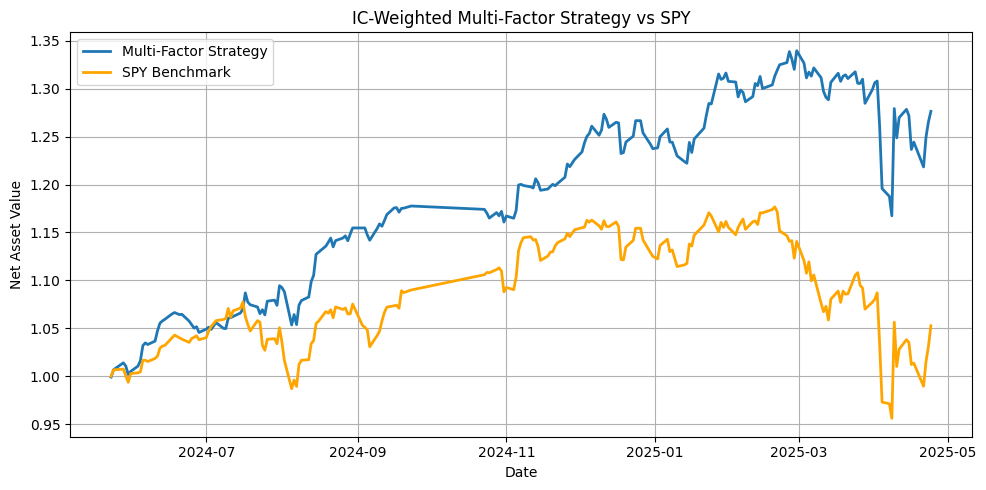

In [ ]:
# -----------------------------------------
# 5. strategy NAV v.s SPY
# -----------------------------------------
portfolio_value = portfolio_value[~portfolio_value.index.duplicated(keep='first')]
# Download SPY data using the date range of the resampled portfolio_value
spy = yf.download('SPY', start=portfolio_value.index[0], end=portfolio_value.index[-1])['Close']
spy_nav = spy / spy.iloc[0]

# Combine the resampled portfolio value with SPY
combined_nav = pd.DataFrame({
    'Multi-Factor Strategy': portfolio_value.squeeze(),
    'SPY': spy_nav.squeeze()
}).dropna()


# visualization
plt.figure(figsize=(10, 5))
plt.plot(combined_nav[ 'Multi-Factor Strategy'], label='Multi-Factor Strategy', linewidth=2)  # 蓝线
plt.plot(combined_nav['SPY'], label='SPY Benchmark', linewidth=2, color='orange')  # 橙线
plt.title("IC-Weighted Multi-Factor Strategy vs SPY")
plt.xlabel("Date")
plt.ylabel("Net Asset Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

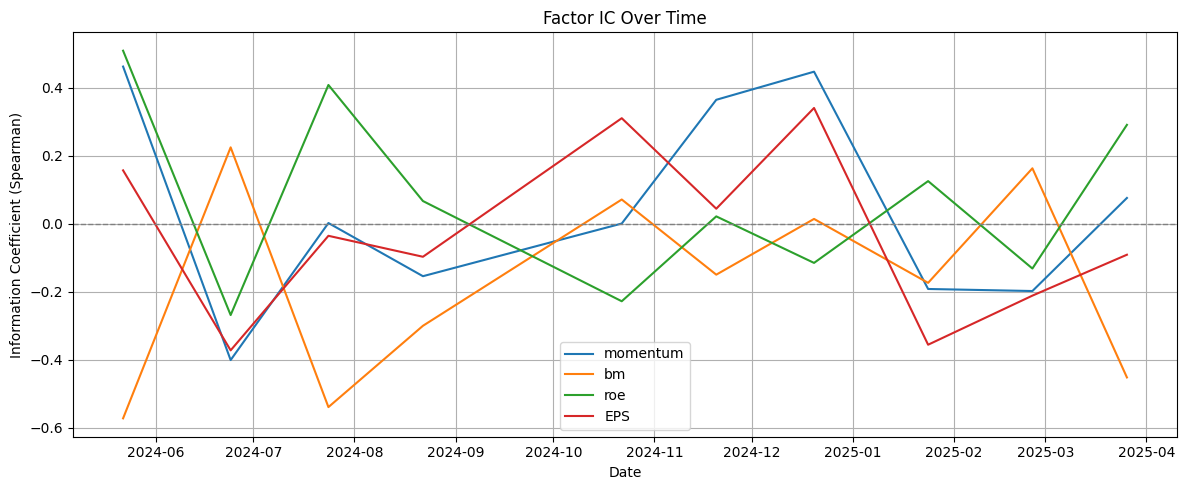

In [ ]:
# -----------------------------------------
# 6. Visualizing factor IC over time
# -----------------------------------------
ic_df = pd.DataFrame(ic_log, index=ic_dates)
plt.figure(figsize=(12, 5))
for col in ic_df.columns:
    plt.plot(ic_df.index, ic_df[col], label=col)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Factor IC Over Time")
plt.xlabel("Date")
plt.ylabel("Information Coefficient (Spearman)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# -----------------------------------------
# 7. key performance metrics
# -----------------------------------------
strategy_returns = combined_nav['Multi-Factor Strategy'].pct_change().dropna()

def compute_performance(returns):
    ann_return = (1 + returns.mean()) ** 252 - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol
    cummax = (1 + returns).cumprod().cummax()
    drawdown = (1 + returns).cumprod() / cummax - 1
    max_dd = drawdown.min()
    calmar = ann_return / abs(max_dd) if max_dd != 0 else np.nan
    return ann_return, ann_vol, sharpe, max_dd, calmar

ar, vol, sharpe, maxdd, calmar = compute_performance(strategy_returns)

print("\n📈 Strategy Performance Summary")
print("Annual Return: {:.2%}".format(ar))
print("Annual Volatility: {:.2%}".format(vol))
print("Sharpe Ratio: {:.2f}".format(sharpe))
print("Max Drawdown: {:.2%}".format(maxdd))
print("Calmar Ratio: {:.2f}".format(calmar))



📈 Strategy Performance Summary
Annual Return: 36.85%
Annual Volatility: 18.55%
Sharpe Ratio: 1.99
Max Drawdown: -12.86%
Calmar Ratio: 2.86


In [ ]:
# -----------------------------------------
#  upgrade methods:replace B/M to gross margin
# -----------------------------------------
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'JPM', 'V', 'JNJ', 'PG', 'NVDA',
           'HD', 'MA', 'DIS', 'PEP', 'KO', 'CSCO', 'XOM', 'PFE', 'MRK', 'WMT']

data_list = []

for t in tickers:
    url = f"https://finviz.com/quote.ashx?t={t}"
    headers = {'User-Agent': 'Mozilla/5.0'}
    soup = BeautifulSoup(requests.get(url, headers=headers).content, "html.parser")

    data = {}
    for td in soup.find_all('td', class_='snapshot-td2'):
        try:
            label = td.text.strip()
            value = td.find_next_sibling('td').text.strip()
            data[label] = value
        except:
            continue

    try:
        gross_margin = float(data.get('Gross Margin', '0%').replace('%', '')) / 100
    except:
        gross_margin = None

    data_list.append({
        'Ticker': t,
        'GrossMargin': gross_margin
    })
    time.sleep(1)

df_margin = pd.DataFrame(data_list).set_index('Ticker')
df_margin.to_csv("gross_margin.csv")
print(df_margin)


        GrossMargin
Ticker             
AAPL         0.4663
MSFT         0.6907
GOOGL        0.5854
AMZN         0.4916
META         0.8175
JPM             NaN
V            0.7710
JNJ          0.6824
PG           0.5140
NVDA         0.7499
HD           0.3152
MA           0.9671
DIS          0.3138
PEP          0.5497
KO           0.6117
CSCO         0.6874
XOM          0.2220
PFE          0.6693
MRK          0.7468
WMT          0.2488


In [ ]:
# replace NA to mean
df_margin.loc['JPM', 'GrossMargin'] = df_margin['GrossMargin'].mean()
print(df_margin)

        GrossMargin
Ticker             
AAPL       0.466300
MSFT       0.690700
GOOGL      0.585400
AMZN       0.491600
META       0.817500
JPM        0.584242
V          0.771000
JNJ        0.682400
PG         0.514000
NVDA       0.749900
HD         0.315200
MA         0.967100
DIS        0.313800
PEP        0.549700
KO         0.611700
CSCO       0.687400
XOM        0.222000
PFE        0.669300
MRK        0.746800
WMT        0.248800


In [ ]:
# combine new factor into original factor dataframe
df = df.join(df_margin[['GrossMargin']])
print(df.head())


           PB       B/M     ROE  EPS_Growth_QQ  GrossMargin
Ticker                                                     
AAPL    46.46  0.021524  1.3802         0.0768       0.4663
MSFT    10.53  0.094967  0.3361         0.1788       0.6907
GOOGL    5.89  0.169779  0.3479         0.4877       0.5854
AMZN     7.07  0.141443  0.2524         0.6233       0.4916
META     8.69  0.115075  0.3983         0.3638       0.8175


In [ ]:
# -----------------------------------------
# repeat step 3. new rolling window parameters
# -----------------------------------------
rebalance_interval = 21
holding_period = 21
portfolio_value1 = pd.Series(dtype=float)
dates = price.index



In [ ]:
# -----------------------------------------
# repeat step 4. backtesting（new factor scoring + IC-weighted + * Softmax）
# -----------------------------------------
GrossMargin = df['GrossMargin']

ic_log = {'momentum': [], 'GrossMargin': [], 'roe': [], 'EPS': []}
ic_dates = []

for i in range(252, len(dates) - holding_period, rebalance_interval):
    date = dates[i]
    next_date = dates[i + holding_period]

    try:
        mom = (price.loc[date - pd.Timedelta(days=21)] / price.loc[date - pd.Timedelta(days=252)]) - 1
    except:
        continue

    factor_df = pd.DataFrame({
        'momentum': mom,
        'GrossMargin': GrossMargin,
        'roe': roe,
        'EPS': EPS
    }).dropna()

    # future return for ic
    fwd_ret = price.loc[next_date] / price.loc[date] - 1
    ic_scores = {}
    for col in factor_df.columns:
        aligned = factor_df[col].align(fwd_ret, join='inner')
        ic = spearmanr(aligned[0], aligned[1]).correlation
        ic_scores[col] = ic if not np.isnan(ic) else 0
        ic_log[col].append(ic_scores[col])
    ic_dates.append(date)

    # normlization + ic-weighted combination
    score = 0
    for col in factor_df.columns:
        z = (factor_df[col] - factor_df[col].mean()) / factor_df[col].std()
        score += ic_scores[col] * z

    score = score.dropna()
    top_stocks = score.sort_values(ascending=False).head(10)

    # Softmax weighted
    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    weights = pd.Series(softmax(top_stocks), index=top_stocks.index)

    try:
        segment = price[weights.index].loc[date:next_date].pct_change().dropna()
        weighted_returns = segment.dot(weights)

        if portfolio_value1.empty:
            portfolio_value1 = (1 + weighted_returns).cumprod()
        else:
            start_val = portfolio_value1.iloc[-1]
            new_vals = (1 + weighted_returns).cumprod() * start_val
            portfolio_value1 = pd.concat([portfolio_value1, new_vals])
    except:
        continue




In [ ]:
print(ic_scores)

{'momentum': np.float64(0.07518796992481201), 'GrossMargin': np.float64(-0.019548872180451125), 'roe': np.float64(0.2902255639097744), 'EPS': np.float64(-0.09172932330827067)}


In [ ]:
factor_df[['roe', 'GrossMargin']].corr(method='spearman')

,roe,GrossMargin
roe,1.000000,0.350376
GrossMargin,0.350376,1.000000


[*********************100%***********************]  1 of 1 completed


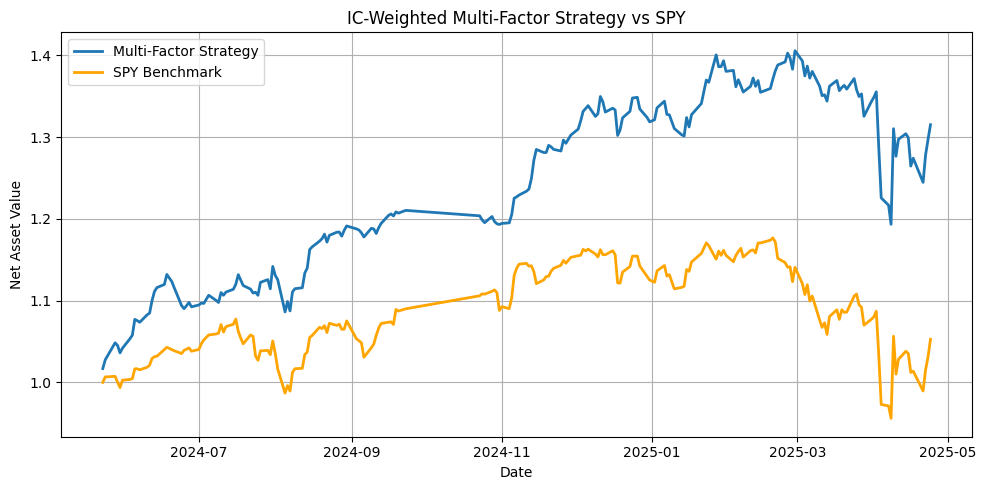

In [ ]:
# -----------------------------------------
# repeat step 5. new strategy NAV v.s SPY
# -----------------------------------------
portfolio_value1 = portfolio_value1[~portfolio_value1.index.duplicated(keep='first')]
# Download SPY data using the date range of the resampled portfolio_value
spy = yf.download('SPY', start=portfolio_value1.index[0], end=portfolio_value1.index[-1])['Close']
spy_nav = spy / spy.iloc[0]

# Combine the resampled portfolio value with SPY
combined_nav = pd.DataFrame({
    'Multi-Factor Strategy': portfolio_value1.squeeze(),
    'SPY': spy_nav.squeeze()
}).dropna()


# visualization
plt.figure(figsize=(10, 5))
plt.plot(combined_nav[ 'Multi-Factor Strategy'], label='Multi-Factor Strategy', linewidth=2)  # 蓝线
plt.plot(combined_nav['SPY'], label='SPY Benchmark', linewidth=2, color='orange')  # 橙线
plt.title("IC-Weighted Multi-Factor Strategy vs SPY")
plt.xlabel("Date")
plt.ylabel("Net Asset Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


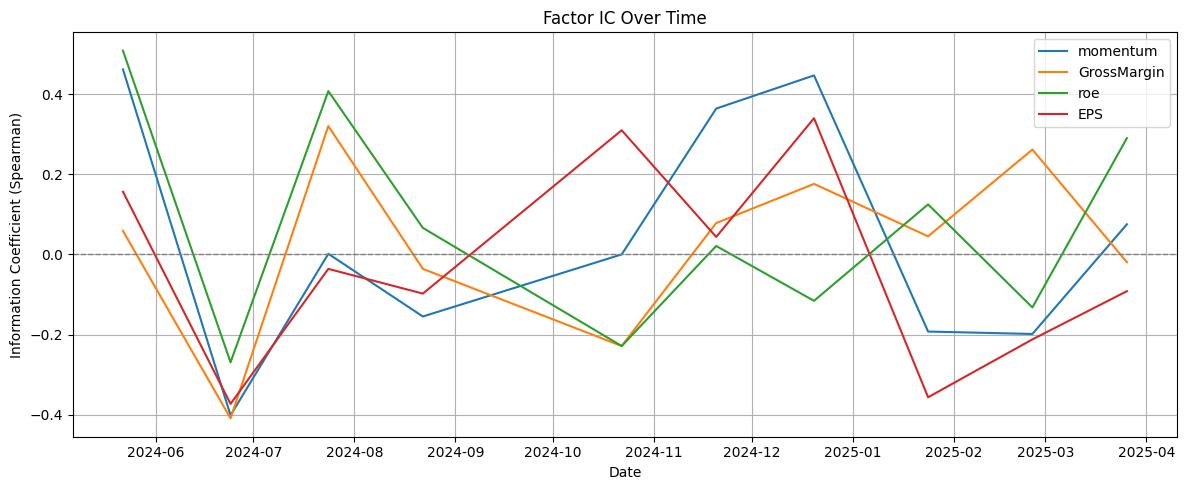

In [ ]:
# -----------------------------------------
# repeat step 6. Visualizing factor IC over time
# -----------------------------------------
ic_df = pd.DataFrame(ic_log, index=ic_dates)
plt.figure(figsize=(12, 5))
for col in ic_df.columns:
    plt.plot(ic_df.index, ic_df[col], label=col)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Factor IC Over Time")
plt.xlabel("Date")
plt.ylabel("Information Coefficient (Spearman)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------------------
# repeat step 7. performance metrics
# -----------------------------------------
strategy_returns = combined_nav['Multi-Factor Strategy'].pct_change().dropna()

def compute_performance(returns):
    ann_return = (1 + returns.mean()) ** 252 - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol
    cummax = (1 + returns).cumprod().cummax()
    drawdown = (1 + returns).cumprod() / cummax - 1
    max_dd = drawdown.min()
    calmar = ann_return / abs(max_dd) if max_dd != 0 else np.nan
    return ann_return, ann_vol, sharpe, max_dd, calmar

ar, vol, sharpe, maxdd, calmar = compute_performance(strategy_returns)

print("\n📈 Strategy Performance Summary")
print("Annual Return: {:.2%}".format(ar))
print("Annual Volatility: {:.2%}".format(vol))
print("Sharpe Ratio: {:.2f}".format(sharpe))
print("Max Drawdown: {:.2%}".format(maxdd))
print("Calmar Ratio: {:.2f}".format(calmar))



📈 Strategy Performance Summary
Annual Return: 39.30%
Annual Volatility: 20.10%
Sharpe Ratio: 1.96
Max Drawdown: -15.10%
Calmar Ratio: 2.60
